# Proyecto 04 - Informe Final Carrera

### Autor: Nicolás Bianco

## Punto de partida: Proyecto 03 - Sistema de recomendación

## Descripción

Tomando como base lo realizado en el proyecto 03, voy a realizar un nuevo modelo de machine learning.

A diferencia de la entrega anterior, donde desarrolle un sistema de recomendación con un filtro colaborativo, lo que voy a desarrollar en este notebook es un filtro basado en contenido 

### Filtro basado en contenido

El objetivo de este filtro es el mismo que el colaborativo, ya que el resultado final de ambos es poder recomendar items a un usuario en particular. Sin embargo, la diferencia principal entre ambos radica en la forma en que busca las recomendaciones.

Basicamente, en un filtro basado en contenido, lo que se hace es encontrar items a recomendar que tengan características similares a los items ya consumidos por el usuario, idealmente en aquellos que se sabe que al usuario le hayan gustado.

Una de las grandes diferencias en el desarrollo de este modelo es construir el perfil del item, ya que este "perfil" será el utilizado para poder encontrar similitudes entre los items. 

Tomando como punto de partida los dataframes limpiados y transformados de los datasets de Steam (juegos y reviews) voy a poder analizar qué caraterísticas tienen los juegos que a un usuario en particular le gustaron y, a partir de esto, poder recomendar juegos parecidos

### Github

Link con el acceso al repositorio https://github.com/greenick1093/Acamica-PRJ

## Librerías

Para comenzar con el proyecto voy a importar las librerías a utilizar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

## Datasets pre-procesados

Dado que en los dataset originales de Steam (reviews y games) ya los había comenzado a limpiar, voy a traerlos a partir de los CSV creados en el proyecto 03

In [2]:
reviews = pd.read_csv('reviews_filtrado_idUsers.csv')
games = pd.read_csv('games_filtrado.csv')

In [3]:
print('Dataset Reviews')
print('Shape:',reviews.shape)
reviews.head()

Dataset Reviews
Shape: (492188, 8)


,username,hours,products,product_id,date,found_funny,early_access_bool,id_user
0,Chaos Syren,0.1,41.0,725280,2017-12-17,0.0,0,1
1,the_maker988,8.2,18.0,35140,2018-01-02,0.0,0,2
2,Szudof,0.2,155.0,288690,2016-08-31,3.0,0,3
3,Vonder,2.7,264.0,35600,2017-04-15,0.0,0,4
4,LucaFox,4.0,136.0,620900,2017-09-11,1.0,0,5


In [4]:
print('Dataset Games')
print('Shape:',games.shape)
games.head()

Dataset Games
Shape: (31817, 12)


,publisher,genres,app_name,title,release_date,tags,specs,early_access,id,developer,sentiment,prices
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],False,761140.0,Kotoshiro,NaN,4.99
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",False,643980.0,Secret Level SRL,Mostly Positive,0.00
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",False,670290.0,Poolians.com,Mostly Positive,0.00
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,2017-12-07,"['Action', 'Adventure', 'Casual']",['Single-player'],False,767400.0,彼岸领域,NaN,0.99
4,NaN,NaN,Log Challenge,NaN,NaN,"['Action', 'Indie', 'Casual', 'Sports']","['Single-player', 'Full controller support', '...",False,773570.0,NaN,NaN,2.99


## EDA - Análisis exploratorio de datos

Ya me encuentro con los datasets a utilizar y nos enfrentamos con una de las principales diferencias a la hora de encarar el desarrollo del modelo de machine learning. 

En el proyecto 03, en el cual desarrollé un filtro colaborativo, el punto clave era analizar, entender y obtener la mayor cantidad de información del dataset de reviews, ya que en ese se encuentran los usuarios con las opiniones sobre sus juegos jugados y la cantidad de horas que jugaron a cada uno, permitiendonos buscar similitudes entre usuarios (por juegos jugados) e inferir los juegos que más les gustaron (cantidad de horas jugadas). Por esta razón es el dataset al cual le dediqué mayor esfuerzo a su limpieza y tratamiento.

En cambio, debido a lo detallado en la descripción de los filtros basados en contenido, el "fuerte" de este algoritmo es encontrar relaciones entre los juegos y sus características (hacerles un perfil). Por esto, el dataset de juegos no tuvo una exhaustiva limpieza, por lo que debo realizarla ahora

In [5]:
games.isna().sum()

publisher       8007
genres          3264
app_name           2
title           2036
release_date    2052
tags             161
specs            609
early_access       0
id                 2
developer       3282
sentiment       7100
prices             0
dtype: int64

In [6]:
# Busco los juegos que no tienen nombre, a ver si coinciden con los que no tienen id
games[games.app_name.isna() == True]

,publisher,genres,app_name,title,release_date,tags,specs,early_access,id,developer,sentiment,prices
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,19.990000
2562,NaN,"['Action', 'Indie']",NaN,NaN,2014-08-26,"['Action', 'Indie']","['Single-player', 'Game demo']",False,317160.0,NaN,Positive,8.866855


In [7]:
# Los elimino ya que no aportan información
games = games[games.app_name.isna() == False]

In [8]:
print('Shape:',games.shape)
games.head()

Shape: (31815, 12)


,publisher,genres,app_name,title,release_date,tags,specs,early_access,id,developer,sentiment,prices
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],False,761140.0,Kotoshiro,NaN,4.99
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",False,643980.0,Secret Level SRL,Mostly Positive,0.00
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",False,670290.0,Poolians.com,Mostly Positive,0.00
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,2017-12-07,"['Action', 'Adventure', 'Casual']",['Single-player'],False,767400.0,彼岸领域,NaN,0.99
4,NaN,NaN,Log Challenge,NaN,NaN,"['Action', 'Indie', 'Casual', 'Sports']","['Single-player', 'Full controller support', '...",False,773570.0,NaN,NaN,2.99


In [9]:
# Busco el juego sin ID
games[games.id.isna() == True]

,publisher,genres,app_name,title,release_date,tags,specs,early_access,id,developer,sentiment,prices
30645,"Warner Bros. Interactive Entertainment, Feral ...","['Action', 'Adventure']",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,2012-09-07,"['Action', 'Open World', 'Batman', 'Adventure'...","['Single-player', 'Steam Achievements', 'Steam...",False,NaN,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,19.99


In [10]:
# Lo elimino
games = games[games.id.isna() == False]

In [11]:
print('Shape:',games.shape)
games.head()

Shape: (31814, 12)


,publisher,genres,app_name,title,release_date,tags,specs,early_access,id,developer,sentiment,prices
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],False,761140.0,Kotoshiro,NaN,4.99
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",False,643980.0,Secret Level SRL,Mostly Positive,0.00
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",False,670290.0,Poolians.com,Mostly Positive,0.00
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,2017-12-07,"['Action', 'Adventure', 'Casual']",['Single-player'],False,767400.0,彼岸领域,NaN,0.99
4,NaN,NaN,Log Challenge,NaN,NaN,"['Action', 'Indie', 'Casual', 'Sports']","['Single-player', 'Full controller support', '...",False,773570.0,NaN,NaN,2.99


#### Eliminación de columnas

Las columnas `publisher`, `developer` y `release_date` las voy a eliminar ya que al haber tantos distintos no van a aportar a la solución, solo van a entorpecerla.

En el caso de la columna `title` también voy a eliminarla ya que hay varios registros vacíos y en su lugar voy a usar la columna "app_name"

In [12]:
games = games.drop(columns=['publisher','developer','title', 'release_date'], axis=1)
games.head()

,genres,app_name,tags,specs,early_access,id,sentiment,prices
0,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],False,761140.0,NaN,4.99
1,"['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",False,643980.0,Mostly Positive,0.00
2,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",False,670290.0,Mostly Positive,0.00
3,"['Action', 'Adventure', 'Casual']",弹炸人2222,"['Action', 'Adventure', 'Casual']",['Single-player'],False,767400.0,NaN,0.99
4,NaN,Log Challenge,"['Action', 'Indie', 'Casual', 'Sports']","['Single-player', 'Full controller support', '...",False,773570.0,NaN,2.99


#### Encoding

##### Columna `early_access`

Como esta columna indica si el juego tuvo o no acceso anticipado la voy a cambiar por 0 (sin acceso anticipado) o 1 (con acceso anticipado)

In [13]:
games['early_access_bool'] = np.where(games['early_access']==True,1,0)
games.head()

,genres,app_name,tags,specs,early_access,id,sentiment,prices,early_access_bool
0,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],False,761140.0,NaN,4.99,0
1,"['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",False,643980.0,Mostly Positive,0.00,0
2,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",False,670290.0,Mostly Positive,0.00,0
3,"['Action', 'Adventure', 'Casual']",弹炸人2222,"['Action', 'Adventure', 'Casual']",['Single-player'],False,767400.0,NaN,0.99,0
4,NaN,Log Challenge,"['Action', 'Indie', 'Casual', 'Sports']","['Single-player', 'Full controller support', '...",False,773570.0,NaN,2.99,0


In [14]:
# Elimino la columna "early_access" ya que no la voy a utilizar
games = games.drop(columns='early_access',axis=1)
games.head()

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool
0,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],761140.0,NaN,4.99,0
1,"['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",643980.0,Mostly Positive,0.00,0
2,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",670290.0,Mostly Positive,0.00,0
3,"['Action', 'Adventure', 'Casual']",弹炸人2222,"['Action', 'Adventure', 'Casual']",['Single-player'],767400.0,NaN,0.99,0
4,NaN,Log Challenge,"['Action', 'Indie', 'Casual', 'Sports']","['Single-player', 'Full controller support', '...",773570.0,NaN,2.99,0


#### Tratamiento de las columnas con listas

Como estamos levantando el dataset del csv, las columnas "genres", "tags" y "specs" las toma como strings, sin embargo son listas. Es por esto que tengo que modificarlas para poder realizarles un mejor tratamiento

In [15]:
print('Generos del primer juego:',games.iloc[0,0])
print('Type:',type(games.iloc[0,0]))

Generos del primer juego: ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy']
Type: <class 'str'>


En los print de recién se evidencia lo dicho anteriormente. 

Para poder convertir estas columnas en listas, voy a utilzar la función de "literal_eval", de manera de convertir las strings en objetos de python, en este caso listas. Me voy a ayudar con una función que me devuelva el objeto y me sea mas sencillo convertir toda la columna

In [16]:
def getPythonObject(lista):
    if type(lista) == str: # Evalúo si la lista es un string, ya que tambien hay "nan"
        return literal_eval(lista) # Si es string, entonces lo convierto en lsita
    else:
        return np.nan # Si no es string, devuelvo un nan


In [17]:
# Comienzo probando con la columna de géneros
games['genres'] = games['genres'].apply(lambda x: getPythonObject(x))
games.head()

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],761140.0,NaN,4.99,0
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",643980.0,Mostly Positive,0.00,0
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",670290.0,Mostly Positive,0.00,0
3,"[Action, Adventure, Casual]",弹炸人2222,"['Action', 'Adventure', 'Casual']",['Single-player'],767400.0,NaN,0.99,0
4,NaN,Log Challenge,"['Action', 'Indie', 'Casual', 'Sports']","['Single-player', 'Full controller support', '...",773570.0,NaN,2.99,0


In [18]:
print('Generos del primer juego:',games.iloc[0,0])
print('Type:',type(games.iloc[0,0]))

Generos del primer juego: ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy']
Type: <class 'list'>


Ahora si, como el resultado de la columna `genres` es satisfactorio, continúo con las otras dos columnas

In [19]:
games['tags'] = games['tags'].apply(lambda x: getPythonObject(x))
games['specs'] = games['specs'].apply(lambda x: getPythonObject(x))
games.head()

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],761140.0,NaN,4.99,0
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",643980.0,Mostly Positive,0.00,0
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",670290.0,Mostly Positive,0.00,0
3,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],767400.0,NaN,0.99,0
4,NaN,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",773570.0,NaN,2.99,0


In [20]:
print('Tags del primer juego:',games.iloc[0,3])
print('Type:',type(games.iloc[0,0]))
print('\nSpecs del primer juego:',games.iloc[0,4])
print('Type:',type(games.iloc[0,0]))

Tags del primer juego: ['Single-player']
Type: <class 'list'>

Specs del primer juego: 761140.0
Type: <class 'list'>


Ahora que tengo estas columnas en los formatos adecuados voy a analizar un poco más en detalle qué valores tiene y cómo se distribuye la cantidad de veces que cada valor aparece.

Para esto voy a utilizar una función que me cree una lista única con todos los valores de las listas

In [21]:
def listaDeListas(listas):
    unicos = []
    for lista in listas:
        #lista = ast.literal_eval(lista)
        #print(lista)
        if (type(lista) == float):
            unicos.append(np.nan)
        else:
            for value in lista:
                unicos.append(value)

    return unicos

In [22]:
generos = listaDeListas(games['genres'])

In [23]:
generos

['Action',
 'Casual',
 'Indie',
 'Simulation',
 'Strategy',
 'Free to Play',
 'Indie',
 'RPG',
 'Strategy',
 'Casual',
 'Free to Play',
 'Indie',
 'Simulation',
 'Sports',
 'Action',
 'Adventure',
 'Casual',
 nan,
 'Action',
 'Adventure',
 'Simulation',
 'Free to Play',
 'Indie',
 'Simulation',
 'Sports',
 'Free to Play',
 'Indie',
 'Simulation',
 'Sports',
 'Free to Play',
 'Indie',
 'Simulation',
 'Sports',
 'Casual',
 'Indie',
 'Racing',
 'Simulation',
 'Action',
 'Indie',
 'Simulation',
 'Early Access',
 nan,
 'Action',
 'Adventure',
 'Casual',
 'Indie',
 'RPG',
 'Casual',
 'Indie',
 'Casual',
 'Indie',
 'Simulation',
 'Adventure',
 'Casual',
 'Indie',
 'Simulation',
 'Strategy',
 'Free to Play',
 'Indie',
 'Simulation',
 'Sports',
 'Adventure',
 'Casual',
 'Indie',
 'Simulation',
 'Strategy',
 nan,
 nan,
 'Action',
 'Adventure',
 'Indie',
 nan,
 'Racing',
 'Simulation',
 'Sports',
 'Racing',
 'Simulation',
 'Sports',
 'Action',
 'Indie',
 nan,
 'Action',
 'Indie',
 'Racing',
 'Act

<AxesSubplot:xlabel='count'>

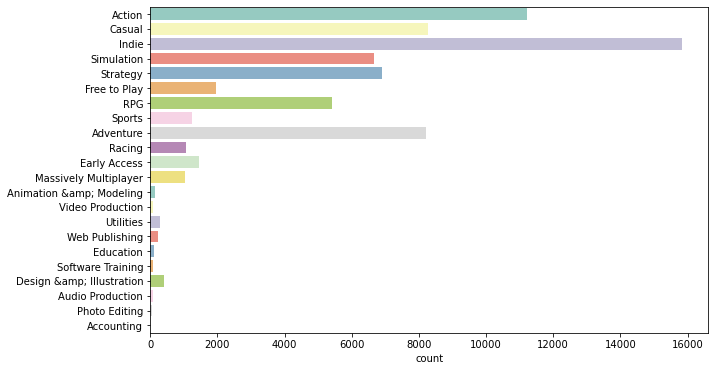

In [24]:
plt.figure(figsize=(10,6))
sns.countplot(y=generos,palette="Set3")

In [25]:
print("Cantidad de valores únicos en lista 'generos':",len(set(generos)))

Cantidad de valores únicos en lista 'generos': 23


In [26]:
tags = listaDeListas(games['tags'])

In [27]:
tags

['Strategy',
 'Action',
 'Indie',
 'Casual',
 'Simulation',
 'Free to Play',
 'Strategy',
 'Indie',
 'RPG',
 'Card Game',
 'Trading Card Game',
 'Turn-Based',
 'Fantasy',
 'Tactical',
 'Dark Fantasy',
 'Board Game',
 'PvP',
 '2D',
 'Competitive',
 'Replay Value',
 'Character Customization',
 'Female Protagonist',
 'Difficult',
 'Design & Illustration',
 'Free to Play',
 'Simulation',
 'Sports',
 'Casual',
 'Indie',
 'Multiplayer',
 'Action',
 'Adventure',
 'Casual',
 'Action',
 'Indie',
 'Casual',
 'Sports',
 'Action',
 'Adventure',
 'Simulation',
 'FPS',
 'Shooter',
 'Third-Person Shooter',
 'Sniper',
 'Third Person',
 'Free to Play',
 'Indie',
 'Simulation',
 'Sports',
 'Free to Play',
 'Indie',
 'Simulation',
 'Sports',
 'Free to Play',
 'Indie',
 'Simulation',
 'Sports',
 'Indie',
 'Casual',
 'Simulation',
 'Racing',
 'Early Access',
 'Action',
 'Indie',
 'Simulation',
 'Survival',
 'Casual',
 'Action',
 'Adventure',
 'RPG',
 'Indie',
 'Casual',
 'Casual',
 'Indie',
 'Pixel Graphic

<AxesSubplot:xlabel='count'>

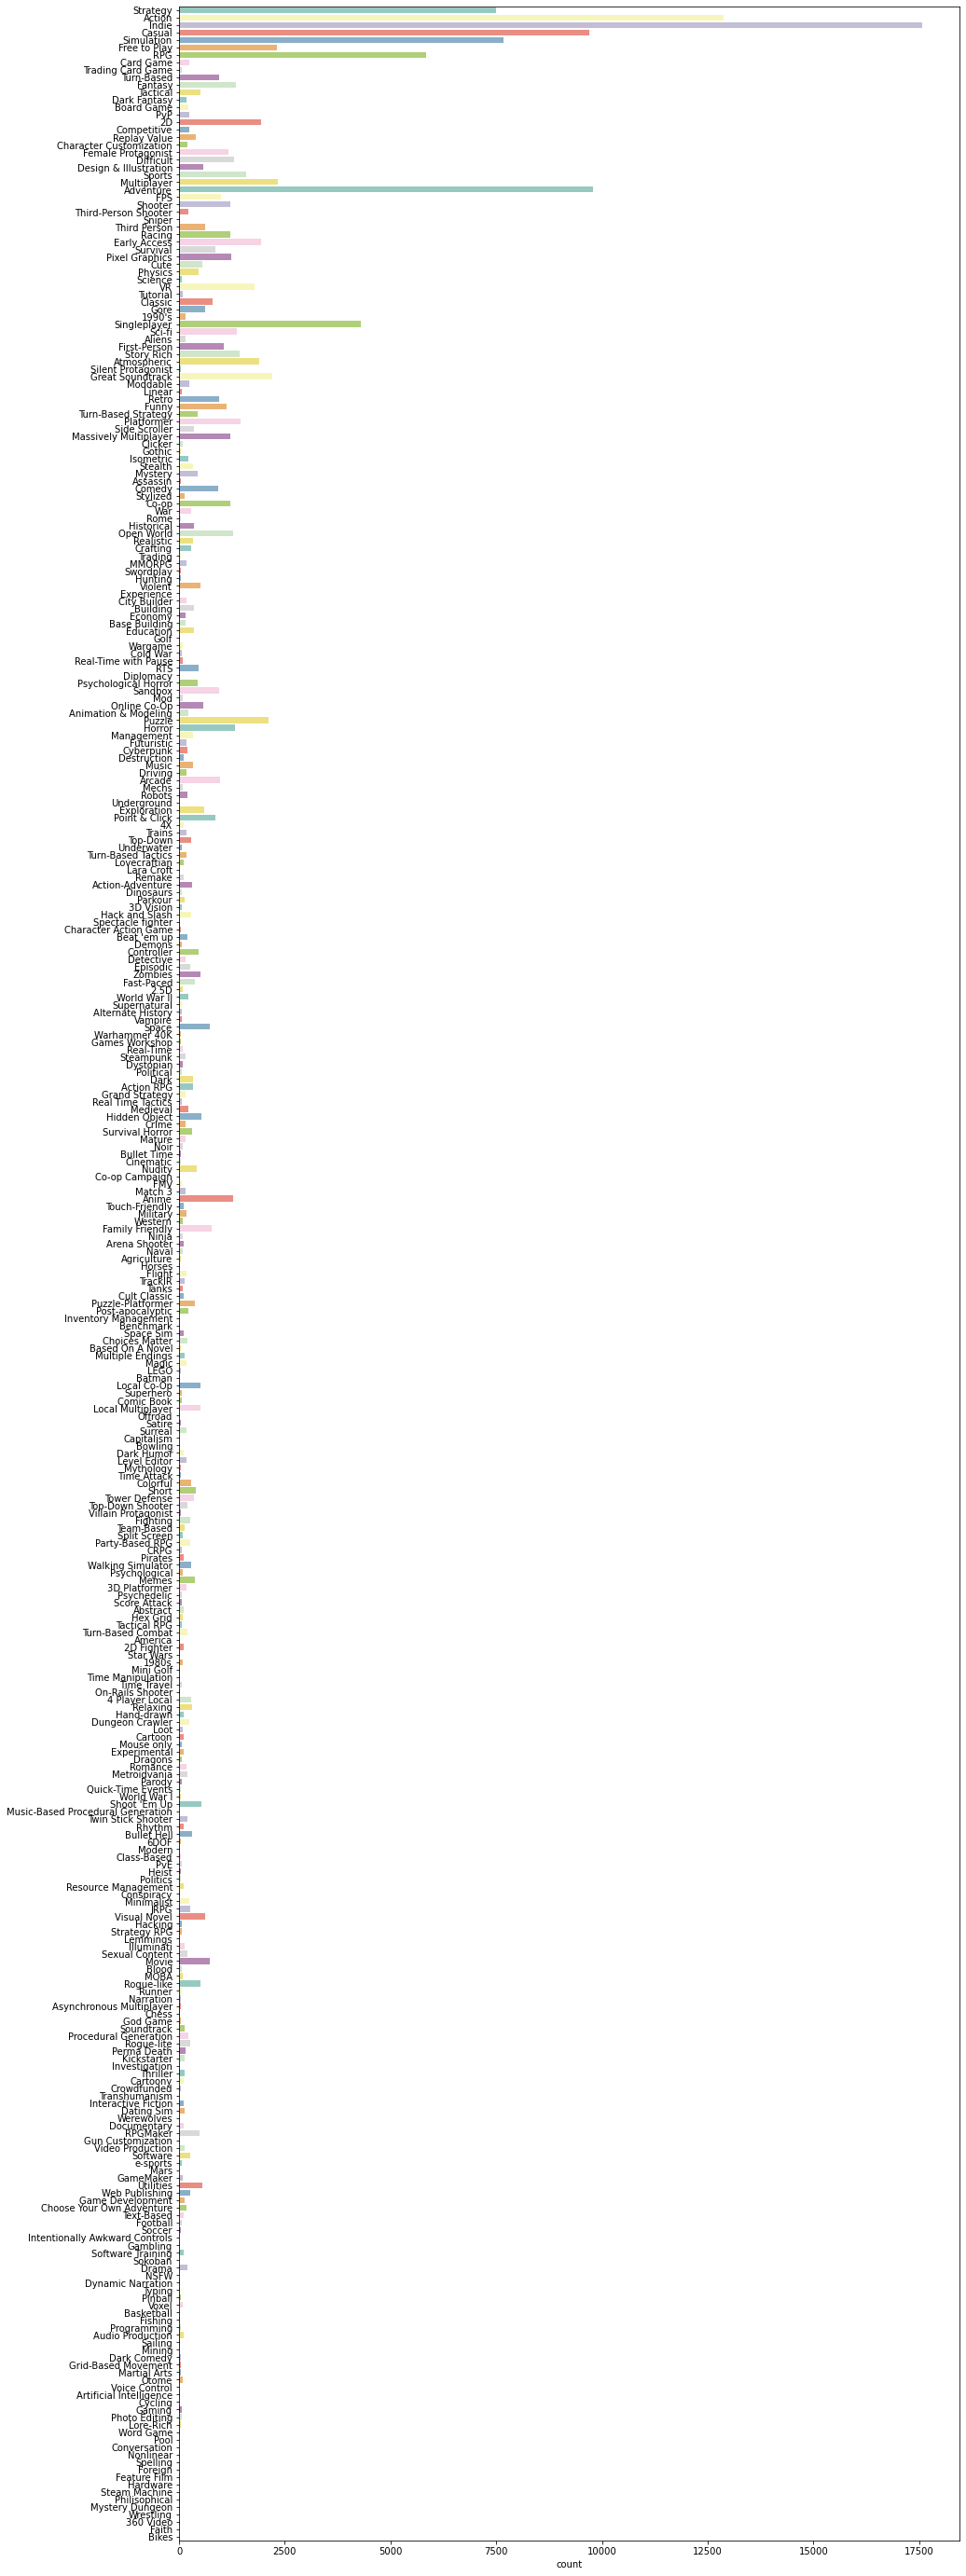

In [28]:
plt.figure(figsize=(15,50))
sns.countplot(y=tags,palette="Set3")

In [29]:
print("Cantidad de valores únicos en lista 'tags':",len(set(tags)))

Cantidad de valores únicos en lista 'tags': 340


In [30]:
specs = listaDeListas(games['specs'])

In [31]:
specs

['Single-player',
 'Single-player',
 'Multi-player',
 'Online Multi-Player',
 'Cross-Platform Multiplayer',
 'Steam Achievements',
 'Steam Trading Cards',
 'In-App Purchases',
 'Single-player',
 'Multi-player',
 'Online Multi-Player',
 'In-App Purchases',
 'Stats',
 'Single-player',
 'Single-player',
 'Full controller support',
 'HTC Vive',
 'Oculus Rift',
 'Tracked Motion Controllers',
 'Room-Scale',
 'Single-player',
 'Steam Achievements',
 'Single-player',
 'Multi-player',
 'Online Multi-Player',
 'Cross-Platform Multiplayer',
 'Downloadable Content',
 'Steam Achievements',
 'Full controller support',
 'Steam Trading Cards',
 'In-App Purchases',
 'Steam Cloud',
 'Steam Leaderboards',
 'Single-player',
 'Multi-player',
 'Online Multi-Player',
 'Cross-Platform Multiplayer',
 'Downloadable Content',
 'Steam Achievements',
 'Full controller support',
 'Steam Trading Cards',
 'In-App Purchases',
 'Steam Cloud',
 'Steam Leaderboards',
 'Single-player',
 'Multi-player',
 'Online Multi-Play

In [32]:
print("Cantidad de valores únicos en lista 'specs':",len(set(specs)))

Cantidad de valores únicos en lista 'specs': 41


<AxesSubplot:xlabel='count'>

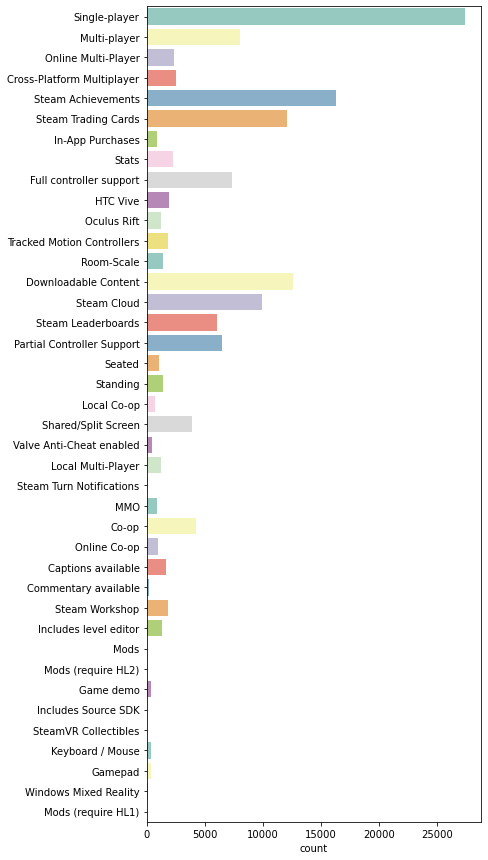

In [33]:
plt.figure(figsize=(6,15))
sns.countplot(y=specs,palette="Set3")

<AxesSubplot:xlabel='count', ylabel='sentiment'>

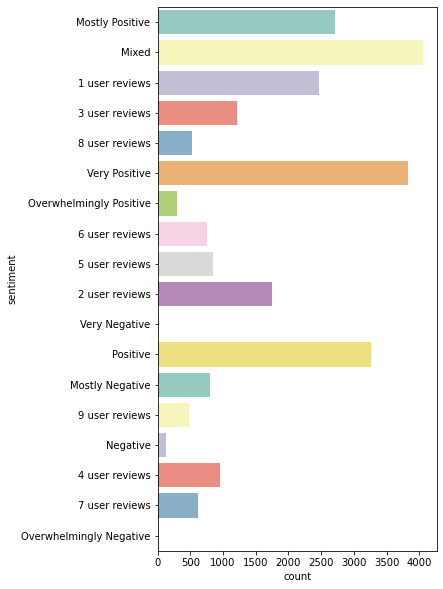

In [34]:
plt.figure(figsize=(5,10))
sns.countplot(data=games, y='sentiment',palette="Set3")

#### Tratamiendo de valores faltantes

##### Columna `specs`

Dado que la gran mayoría de los juegos tiene como spec "single-player", voy a ponerle a los valores faltantes una lista con dicho valor

In [35]:
spec = ['Single-player']
spec

['Single-player']

In [36]:
# Como no se puede usar la función 'fillna()' ya que estaría completando los valores faltantes con una lista, 
# voy a recorrer toda la columna y reemplazar los nan con una lista
games['specs'] = games['specs'].apply(lambda x: x if isinstance(x, list) else spec)

In [37]:
games.specs.isna().sum()

0

##### Columna `sentiment`

In [38]:
games[games.sentiment.isna() == True] # Busco los juegos que tienen un null en la columna 'sentiment'

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],761140.0,NaN,4.990000,0
3,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],767400.0,NaN,0.990000,0
4,NaN,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",773570.0,NaN,2.990000,0
6,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Basic Pass,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",774276.0,NaN,9.990000,0
7,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Pro Pass,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",774277.0,NaN,18.990000,0
...,...,...,...,...,...,...,...,...
31807,"[Action, Adventure, Indie]",The spy who shot me™,"[Action, Adventure, Indie]","[Single-player, Captions available]",771810.0,NaN,8.866855,0
31810,"[Casual, Indie]",BAE 2,"[Indie, Casual]",[Single-player],769330.0,NaN,8.866855,0
31812,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,"[Strategy, Indie, Casual, Simulation]","[Single-player, Steam Achievements]",773640.0,NaN,1.990000,0
31813,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,"[Strategy, Indie, Casual]","[Single-player, Steam Achievements, Steam Clou...",733530.0,NaN,4.990000,0


In [39]:
games.corr()

,id,prices,early_access_bool
id,1.000000,-0.109956,0.105289
prices,-0.109956,1.000000,0.058810
early_access_bool,0.105289,0.058810,1.000000


Dado que no se puede evidenciar una relación entre la columna 'sentiment' con las demás columnas y tampoco se puede relacionar los diferentes valores de 'sentiment' con 'tags' o 'genres', lo que voy a hacer es completar los valores nulos eligiendo un valor random de la lista

In [40]:
# hago un groupby por la cantidad de veces que aparece cada valor, y solo veo los 10 primeros valores (mas cantidad de ocurrencias)
games.groupby('sentiment').count().sort_values(by='tags',ascending=False).head(10)

,genres,app_name,tags,specs,id,prices,early_access_bool
sentiment,,,,,,,
Mixed,3803,4060,4052,4060,4060,4060,4060
Very Positive,3579,3827,3827,3827,3827,3827,3827
Positive,2843,3257,3244,3257,3257,3257,3257
Mostly Positive,2506,2707,2702,2707,2707,2707,2707
1 user reviews,2174,2472,2459,2472,2472,2472,2472
2 user reviews,1535,1741,1730,1741,1741,1741,1741
3 user reviews,1053,1219,1211,1219,1219,1219,1219
4 user reviews,841,953,949,953,953,953,953
5 user reviews,732,841,831,841,841,841,841


In [41]:
# Como ya vi que funciona bien, me traigo a la lista los index que tienen más probabilidad de ocurrencia
lista_random = games.groupby('sentiment').count().sort_values(by='tags',ascending=False).head(10).index
lista_random

Index(['Mixed', 'Very Positive', 'Positive', 'Mostly Positive',
       '1 user reviews', '2 user reviews', '3 user reviews', '4 user reviews',
       '5 user reviews', 'Mostly Negative'],
      dtype='object', name='sentiment')

In [42]:
# Ahora si, completo los valores nulos con la elección al azar de la lista de 'sentimet' antes creada
games['sentiment'] = games['sentiment'].fillna(pd.Series(np.random.choice(lista_random, size=len(games.index)+1)))
games.head()

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],761140.0,2 user reviews,4.99,0
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",643980.0,Mostly Positive,0.00,0
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",670290.0,Mostly Positive,0.00,0
3,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],767400.0,Mostly Positive,0.99,0
4,NaN,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",773570.0,Positive,2.99,0


In [43]:
games.sentiment.isna().sum()

0

Ahora quedan por ver las columnas más complejas de analizar, ya que son "genres" y "tags". Voy a comenzar contando la cantidad de valores faltantes de cada columna para ver su mejor tratamiento

In [44]:
games[games.genres.isna()==True]

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool
4,NaN,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",773570.0,Positive,2.99,0
11,NaN,Icarus Six Sixty Six,[Casual],"[Single-player, HTC Vive, Tracked Motion Contr...",724910.0,Mostly Positive,0.00,0
18,NaN,After Life VR,"[Early Access, Indie, VR]","[Single-player, HTC Vive, Tracked Motion Contr...",772590.0,3 user reviews,4.99,1
19,NaN,Kitty Hawk,"[Early Access, Action, Adventure, Indie, Casual]","[Single-player, Steam Leaderboards, HTC Vive, ...",640250.0,3 user reviews,2.99,1
21,NaN,Mortars VR,"[Early Access, Strategy, Action, Indie, Casual...","[Single-player, Multi-player, Online Multi-Pla...",711440.0,8 user reviews,0.99,1
...,...,...,...,...,...,...,...,...
31800,NaN,Robotpencil Presents: Exercise: Brushwork,"[Design & Illustration, Tutorial]",[Single-player],775640.0,2 user reviews,3.99,0
31801,NaN,Robotpencil Presents: Creative Composition,"[Design & Illustration, Tutorial]",[Single-player],777930.0,Mostly Negative,3.99,0
31802,NaN,The Gamble House,[Movie],[Captions available],775370.0,3 user reviews,4.99,0
31803,NaN,Kalen Chock Presents: 2017 Free Tutorial,"[Design & Illustration, Tutorial]",[Single-player],777950.0,Mostly Positive,0.00,0


In [45]:
games[games.tags.isna()==True]

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool
278,[Adventure],Nancy Drew®: Ransom of the Seven Ships Demo,NaN,"[Single-player, Game demo]",31990.0,3 user reviews,8.866855,0
297,"[Action, Adventure]",Mini Ninjas Demo,NaN,"[Single-player, Game demo]",35050.0,Positive,8.866855,0
308,[Casual],Freeze Tag Fun Pack #2,NaN,[Single-player],39392.0,Positive,19.990000,0
309,[Casual],Freeze Tag Fun Pack #1,NaN,[Single-player],39391.0,Mostly Negative,19.990000,0
357,NaN,Europa Universalis III: Heir to the Throne,NaN,"[Single-player, Multi-player, Downloadable Con...",25806.0,Positive,9.990000,0
...,...,...,...,...,...,...,...,...
31307,[Casual],Zenerchi®,NaN,[Single-player],37290.0,5 user reviews,9.990000,0
31309,[Simulation],Wedding Dash® 2: Rings Around the World,NaN,[Single-player],37280.0,Positive,9.990000,0
31321,NaN,Super Granny Collection,NaN,[Single-player],36270.0,6 user reviews,14.990000,0
31334,[Indie],Bad Rats: the Rats' Revenge Demo,NaN,"[Single-player, Game demo]",34910.0,Mixed,8.866855,0


Al ser alrededor de 3000 registros los que contienen estos valores nulos, voy a eliminarlos

In [46]:
games = games.dropna(subset=['genres', 'tags'])

In [47]:
print('Shape:',games.shape)
games.head()

Shape: (28528, 8)


,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],761140.0,2 user reviews,4.99,0
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",643980.0,Mostly Positive,0.00,0
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",670290.0,Mostly Positive,0.00,0
3,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],767400.0,Mostly Positive,0.99,0
5,"[Action, Adventure, Simulation]",Battle Royale Trainer,"[Action, Adventure, Simulation, FPS, Shooter, ...","[Single-player, Steam Achievements]",772540.0,Mixed,3.99,0


### Modelo de Machine Learning

El modelo de machine learning que voy a realizar se basa en encontrar similitudes entre las caraterísticas de los juegos, para así poder recomendar. 

De acuerdo a lo que busqué en diferentes lugares, hay varias maneras de hacerlo, con diferentes librerías y formas de encararlo. Una de las formas que más recomiendan de acuerdo a sus resultados es utilzando: 
 - Metadata: Basicamente es datos sobre los datos. A partir de las diferentes columnas se deben agrupar todos los datos para que el algoritmo tenga de donde aprender y así poder recomendar
 -`CountVecotizer`: Se encuentra en la librería de ScikitLearn. Lo voy a utilizar para poder constriuir un feature numérico a partir de la metadata. Esto va a permitir la conversión de todo el texto en una matriz en donde se cuente la cantidad de veces que aparece cada palabra
 -`cosine_similarity`: También se encuentra en la librería de ScikitLearn. Lo voy a usar como "métrica" para poder medir la similitud entre dos juegos para así poder recomendar entre aquellos que tienen la mejor métrica, ya que estos en teoría serían más similares

Luego de buscar diferentes formas de hacerlo, noté que en general suelen separarlo en las siguientes fases:
 - Preparación de metadata
 - Armar la matriz de vectorización
 - Armar la matriz de similitud
 - Crear una función de recomendación

#### Preparación de metadata

En las columnas `genres`, `tags` y `specs` puede haber demasiados valores, lo que complica el análisis. Es por esto que de cada lista, solo voy a quedarme con sus 3 primeros valores. Para los tags, al darle un poco mas de especificidad, voy a quedarme con los 5 primeros

In [48]:
games['genres'] = games['genres'].apply(lambda x: x[:3] if len(x)>3 else x)
games['tags'] = games['tags'].apply(lambda x: x[:5] if len(x)>3 else x)
games['specs'] = games['specs'].apply(lambda x: x[:3] if len(x)>3 else x)
games.head()

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool
0,"[Action, Casual, Indie]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],761140.0,2 user reviews,4.99,0
1,"[Free to Play, Indie, RPG]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game]","[Single-player, Multi-player, Online Multi-Pla...",643980.0,Mostly Positive,0.00,0
2,"[Casual, Free to Play, Indie]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Indie]","[Single-player, Multi-player, Online Multi-Pla...",670290.0,Mostly Positive,0.00,0
3,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],767400.0,Mostly Positive,0.99,0
5,"[Action, Adventure, Simulation]",Battle Royale Trainer,"[Action, Adventure, Simulation, FPS, Shooter]","[Single-player, Steam Achievements]",772540.0,Mixed,3.99,0


In [49]:
# Le saco los espacios a las columnas para que sea más entendible luego de vectorizar
games['genres'] = games['genres'].apply(lambda x: [i.replace(' ','') for i in x])
games['tags'] = games['tags'].apply(lambda x: [i.replace(' ','') for i in x])
games['specs'] = games['specs'].apply(lambda x: [i.replace(' ','') for i in x])
games['sentiment'] = games['sentiment'].apply(lambda x: [x.replace(' ','')])

In [50]:
games.head()

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool
0,"[Action, Casual, Indie]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],761140.0,[2userreviews],4.99,0
1,"[FreetoPlay, Indie, RPG]",Ironbound,"[FreetoPlay, Strategy, Indie, RPG, CardGame]","[Single-player, Multi-player, OnlineMulti-Player]",643980.0,[MostlyPositive],0.00,0
2,"[Casual, FreetoPlay, Indie]",Real Pool 3D - Poolians,"[FreetoPlay, Simulation, Sports, Casual, Indie]","[Single-player, Multi-player, OnlineMulti-Player]",670290.0,[MostlyPositive],0.00,0
3,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],767400.0,[MostlyPositive],0.99,0
5,"[Action, Adventure, Simulation]",Battle Royale Trainer,"[Action, Adventure, Simulation, FPS, Shooter]","[Single-player, SteamAchievements]",772540.0,[Mixed],3.99,0


##### Creación de la columna "metadata"

In [51]:
# Hago una columna que contenga toda la información de cada pelicula. Esta servirá como metadata
games['metadata'] = games.apply(lambda x: ''.join(x['genres']) + ''+''.join(x['tags']) + '' + ''.join(x['specs']) + '' + ''.join(x['sentiment']), axis=1)
games.head()

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool,metadata
0,"[Action, Casual, Indie]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],761140.0,[2userreviews],4.99,0,ActionCasualIndieStrategyActionIndieCasualSimu...
1,"[FreetoPlay, Indie, RPG]",Ironbound,"[FreetoPlay, Strategy, Indie, RPG, CardGame]","[Single-player, Multi-player, OnlineMulti-Player]",643980.0,[MostlyPositive],0.00,0,FreetoPlayIndieRPGFreetoPlayStrategyIndieRPGCa...
2,"[Casual, FreetoPlay, Indie]",Real Pool 3D - Poolians,"[FreetoPlay, Simulation, Sports, Casual, Indie]","[Single-player, Multi-player, OnlineMulti-Player]",670290.0,[MostlyPositive],0.00,0,CasualFreetoPlayIndieFreetoPlaySimulationSport...
3,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],767400.0,[MostlyPositive],0.99,0,ActionAdventureCasualActionAdventureCasualSing...
5,"[Action, Adventure, Simulation]",Battle Royale Trainer,"[Action, Adventure, Simulation, FPS, Shooter]","[Single-player, SteamAchievements]",772540.0,[Mixed],3.99,0,ActionAdventureSimulationActionAdventureSimula...


In [52]:
# Para que no haya inconvenientes con los index del dataframe, voy a resetearlos
games = games.reset_index(drop=True)

In [53]:
games

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool,metadata
0,"[Action, Casual, Indie]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],761140.0,[2userreviews],4.99,0,ActionCasualIndieStrategyActionIndieCasualSimu...
1,"[FreetoPlay, Indie, RPG]",Ironbound,"[FreetoPlay, Strategy, Indie, RPG, CardGame]","[Single-player, Multi-player, OnlineMulti-Player]",643980.0,[MostlyPositive],0.00,0,FreetoPlayIndieRPGFreetoPlayStrategyIndieRPGCa...
2,"[Casual, FreetoPlay, Indie]",Real Pool 3D - Poolians,"[FreetoPlay, Simulation, Sports, Casual, Indie]","[Single-player, Multi-player, OnlineMulti-Player]",670290.0,[MostlyPositive],0.00,0,CasualFreetoPlayIndieFreetoPlaySimulationSport...
3,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],767400.0,[MostlyPositive],0.99,0,ActionAdventureCasualActionAdventureCasualSing...
4,"[Action, Adventure, Simulation]",Battle Royale Trainer,"[Action, Adventure, Simulation, FPS, Shooter]","[Single-player, SteamAchievements]",772540.0,[Mixed],3.99,0,ActionAdventureSimulationActionAdventureSimula...
...,...,...,...,...,...,...,...,...,...
28523,"[Action, Adventure, Casual]",Kebab it Up!,"[Action, Indie, Casual, Violent, Adventure]","[Single-player, SteamAchievements, SteamCloud]",745400.0,[2userreviews],1.99,0,ActionAdventureCasualActionIndieCasualViolentA...
28524,"[Casual, Indie, Simulation]",Colony On Mars,"[Strategy, Indie, Casual, Simulation]","[Single-player, SteamAchievements]",773640.0,[VeryPositive],1.99,0,CasualIndieSimulationStrategyIndieCasualSimula...
28525,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,"[Strategy, Indie, Casual]","[Single-player, SteamAchievements, SteamCloud]",733530.0,[MostlyNegative],4.99,0,CasualIndieStrategyStrategyIndieCasualSingle-p...
28526,"[Indie, Racing, Simulation]",Russian Roads,"[Indie, Simulation, Racing]","[Single-player, SteamAchievements, SteamTradin...",610660.0,[Positive],1.99,0,IndieRacingSimulationIndieSimulationRacingSing...


#### Armar la matriz de vectorización

Como mencioné antes, aca voy a utilzar la función de CountVectorizer() de sklearn

In [54]:
countVec = CountVectorizer()
count_vec_matriz = countVec.fit_transform(games['metadata']) # Aprende del diccionario todos los "tokens" de cada fila 

Imprimo para ver el array que mapea los índices de cada feature con su nombre y luego imprimo la matriz

In [55]:
print(countVec.get_feature_names())

['3userreviews', '5dplatformersingle', '5dsingle', '5dstealthassassinsingle', '5dsuperherosingle', '5userreviews', 'accountinganimation', 'accountingsoftwareeducationgreatsoundtrackatmosphericsingle', 'accountingutilitiesutilitiesfreetoplayeconomysoftwaresingle', 'action2dfighteractionfightinganimesingleplayersingle', 'actionaction1990', 'actionaction2dfighterfightingarcadesingle', 'actionaction2dpixelgraphicsarcadesingle', 'actionaction4playerlocalcolorfullocalco', 'actionaction4playerlocallocalmultiplayercartooncompetitiveshared', 'actionactionadventuregreatsoundtrackclassic3dplatformersingle', 'actionactionadventurelaracroftfemaleprotagonistthirdpersonsingle', 'actionactionadventuresingle', 'actionactionanimefighting2dfighterarcadesingle', 'actionactionanimeon', 'actionactionanimesingle', 'actionactionarcade1980sbeat', 'actionactionarcade2dsidescrollerclassicsingle', 'actionactionarcade2dsidescrollershoot', 'actionactionarcadebeat', 'actionactionarcadecasualretromultiplayersingle', 

In [56]:
print(count_vec_matriz.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### Armar la matriz de similitud

Para la similitud entre los juegos voy a usar la función de sklearn de `cosine_similarity`, la cual mide la "distancia" (en este caso similitud) entre dos vectores x e y

In [57]:
cosineSim_matriz = cosine_similarity(count_vec_matriz, count_vec_matriz) # Al pasarle tanto en el "x" como el "y" la matriz del count vectorizer, formo una matriz de similitud de todos con todos

In [58]:
print(cosineSim_matriz.shape)
cosineSim_matriz

(28528, 28528)


array([[1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.75, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.75, 1.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ]])

Como se puede observar, la matriz evalúa cada valor con los demás. Es por esto que la diagonal principal es siempre 1. A modo de analogía, es como hacer una matriz de correlación entre variables

Para continuar tengo que poner como index del dataframe el nombre de los juegos, ya que de esta forma se va a poder evaluar las recomendaciones de los juegos

In [59]:
mapeo = pd.Series(games.index,index= games['app_name'])

In [60]:
mapeo

app_name
Lost Summoner Kitty             0
Ironbound                       1
Real Pool 3D - Poolians         2
弹炸人2222                         3
Battle Royale Trainer           4
                            ...  
Kebab it Up!                28523
Colony On Mars              28524
LOGistICAL: South Africa    28525
Russian Roads               28526
EXIT 2 - Directions         28527
Length: 28528, dtype: int64

#### Crear una función de recomendación

In [61]:
def recomendarJuegos(game):
    game_index = mapeo[game]
    
    # Busco la similitud con otros juegos
    similitud = list(enumerate(cosineSim_matriz[game_index]))
    similitud = sorted(similitud, key=lambda x: x[1], reverse=True)
    
    # Busco los primeros 10 ya que deberían ser los 10 más parecidos.
    similitud = similitud[1:11] # Es del 1 al 11 ya que el 0 sería el mismo juego que estoy pasando de parámetro
    
    game_indices = [i[0] for i in similitud]
    
    return (games['app_name'].iloc[game_indices])

Para probar la función de recomendación voy a buscar juegos que conozca para ver qué me recomienda. En principio voy a buscar juegos que sean de Batman

In [62]:
games[games['app_name'].str.contains('Batman')]

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool,metadata
161,"[Action, Adventure]",LEGO Batman,"[LEGO, Action, Adventure, Batman, LocalCo-Op]","[Single-player, Shared/SplitScreen, Fullcontro...",21000.0,[VeryPositive],19.990000,0,ActionAdventureLEGOActionAdventureBatmanLocalC...
755,[Action],Batman Arkham City: Nightwing Bundle,[Action],"[Single-player, DownloadableContent]",200880.0,[2userreviews],8.866855,0,ActionActionSingle-playerDownloadableContent2u...
760,[Action],Batman Arkham City: Robin Bundle,"[Action, Batman]","[Single-player, DownloadableContent]",200870.0,[2userreviews],8.866855,0,ActionActionBatmanSingle-playerDownloadableCon...
796,[Action],Batman Arkham City: Challenge Map Pack,[Action],"[Single-player, DownloadableContent]",200890.0,[2userreviews],8.866855,0,ActionActionSingle-playerDownloadableContent2u...
797,[Action],Batman Arkham City: Arkham City Skins Pack,"[Action, Batman]","[Single-player, DownloadableContent]",200860.0,[3userreviews],8.866855,0,ActionActionBatmanSingle-playerDownloadableCon...
926,"[Action, Adventure]",LEGO® Batman 2 DC Super Heroes™,"[LEGO, Action, Batman, Adventure, OpenWorld]","[Single-player, Shared/SplitScreen, Fullcontro...",213330.0,[VeryPositive],19.990000,0,ActionAdventureLEGOActionBatmanAdventureOpenWo...
1020,"[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,"[Action, OpenWorld, Batman, Adventure, Stealth]","[Single-player, SteamAchievements, SteamTradin...",200260.0,[OverwhelminglyPositive],19.990000,0,ActionAdventureActionOpenWorldBatmanAdventureS...
1664,"[Action, Adventure]",Batman: Arkham Origins - New Millennium Skins ...,"[Action, Adventure]","[Single-player, Multi-player, DownloadableCont...",237620.0,[MostlyPositive],4.990000,0,ActionAdventureActionAdventureSingle-playerMul...
1726,"[Action, Adventure]",Batman: Arkham Origins - Initiation,"[Action, Adventure, Batman]","[Single-player, Multi-player, DownloadableCont...",237619.0,[Mixed],6.990000,0,ActionAdventureActionAdventureBatmanSingle-pla...
2762,"[Action, Adventure]",LEGO Batman 3: Beyond Gotham DLC: Man of Steel,"[Action, Adventure]","[Single-player, Shared/SplitScreen, Downloadab...",327170.0,[MostlyPositive],2.990000,0,ActionAdventureActionAdventureSingle-playerSha...


In [63]:
# Ahora sí, recomiendo un juego
lista = recomendarJuegos('LEGO Batman')
lista

24791                         Disney Universe
926           LEGO® Batman 2 DC Super Heroes™
1806                         Luxuria Superbia
1841               BlazBlue: Calamity Trigger
2332                    Hidden in Plain Sight
3716                            Miner Warfare
23836                     Disney•Pixar WALL-E
270                  Bionic Commando: Rearmed
324      LEGO® Star Wars™ - The Complete Saga
654                 Tobe's Vertical Adventure
Name: app_name, dtype: object

In [64]:
games[games['app_name']== 'LEGO Batman']

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool,metadata
161,"[Action, Adventure]",LEGO Batman,"[LEGO, Action, Adventure, Batman, LocalCo-Op]","[Single-player, Shared/SplitScreen, Fullcontro...",21000.0,[VeryPositive],19.99,0,ActionAdventureLEGOActionAdventureBatmanLocalC...


In [65]:
games[games.app_name.isin(lista)] # Quiero ver en detalle los juegos que me recomendó mi función para compararlo con "LEGO Batman"

,genres,app_name,tags,specs,id,sentiment,prices,early_access_bool,metadata
270,[Action],Bionic Commando: Rearmed,"[Action, Platformer, Remake, GreatSoundtrack, ...","[Single-player, Shared/SplitScreen, PartialCon...",21680.0,[MostlyPositive],9.99,0,ActionActionPlatformerRemakeGreatSoundtrackLoc...
324,[Adventure],LEGO® Star Wars™ - The Complete Saga,"[LEGO, StarWars, Adventure, LocalCo-Op, Family...","[Single-player, Shared/SplitScreen, Fullcontro...",32440.0,[VeryPositive],19.99,0,AdventureLEGOStarWarsAdventureLocalCo-OpFamily...
654,"[Action, Adventure, Indie]",Tobe's Vertical Adventure,"[Indie, Action, Adventure, Platformer, LocalCo...","[Single-player, Shared/SplitScreen, SteamAchie...",105700.0,[MostlyPositive],0.99,0,ActionAdventureIndieIndieActionAdventurePlatfo...
926,"[Action, Adventure]",LEGO® Batman 2 DC Super Heroes™,"[LEGO, Action, Batman, Adventure, OpenWorld]","[Single-player, Shared/SplitScreen, Fullcontro...",213330.0,[VeryPositive],19.99,0,ActionAdventureLEGOActionBatmanAdventureOpenWo...
1806,"[Action, Casual, Indie]",Luxuria Superbia,"[Indie, Casual, Simulation, Psychedelic, Action]","[Single-player, Shared/SplitScreen, Fullcontro...",269150.0,[VeryPositive],6.99,0,ActionCasualIndieIndieCasualSimulationPsychede...
1841,[Action],BlazBlue: Calamity Trigger,"[Fighting, Anime, 2DFighter, Arcade, GreatSoun...","[Single-player, Shared/SplitScreen, Fullcontro...",263300.0,[VeryPositive],9.99,0,ActionFightingAnime2DFighterArcadeGreatSoundtr...
2332,"[Action, Casual]",Hidden in Plain Sight,"[Casual, LocalMultiplayer, Action, 4PlayerLoca...","[LocalMulti-Player, Shared/SplitScreen, Fullco...",303590.0,[VeryPositive],5.99,0,ActionCasualCasualLocalMultiplayerAction4Playe...
3716,"[Action, Casual, Indie]",Miner Warfare,"[Indie, 4PlayerLocal, LocalMultiplayer, Casual...","[Multi-player, Shared/SplitScreen, Fullcontrol...",354620.0,[VeryPositive],2.99,0,ActionCasualIndieIndie4PlayerLocalLocalMultipl...
23836,[Adventure],Disney•Pixar WALL-E,"[Adventure, Robots, Space, Puzzle, Multiplayer]","[Single-player, Shared/SplitScreen, Fullcontro...",331750.0,[VeryPositive],19.99,0,AdventureAdventureRobotsSpacePuzzleMultiplayer...
24791,"[Action, Adventure]",Disney Universe,"[FamilyFriendly, Adventure, Action, Cartoony, ...","[Single-player, Shared/SplitScreen, Fullcontro...",316260.0,[VeryPositive],19.99,0,ActionAdventureFamilyFriendlyAdventureActionCa...


#### Análisis de las recomendaciones

Considero que las recomendaciones son bastante acertadas ya que todos los juegos recomendados tienen las mismas (o parecidas) características. 
 - Géneros: Son todos de acción y/o aventuras
 - Tags: Las etiquetas coinciden bastante bien
 - Especificaciones: Todos los juegos son single player y/o permiten compartir o dividir pantalla
 - Sentimientos: En general son todos 'Very Positive'

### Conclusiones finales

Luego de realizar este sistema de recomendación puedo decir que estoy conforme con los resultados obtenidos, al ser mi primer modelo de machine learning de este tipo creo que las recomendaciones de los juegos que obtuve son bastante acertadas. 

Al realizar una comparación con el modelo anterior (filtro colaborativo) puedo concluir que ambos son muy útiles y, en mi opinión, no habría que elegir entre uno y el otro, sino más bien combinarlos. Al realizar recomendaciones basandonos en los dos algoritmos las probabilidades de acertar con los gustos del usuario serían mucho mayores.

Por otro lado, como punto de mejora para estos sistemas de recomendación es entender un poco más al usuario en cuanto a su comportamiento. Un ejemplo sencillo pudiese ser lo que suele gastar en los juegos, ya que si es un usuario que siempre jugó juegos gratuitos, sería poco probable que desee gastar dinero. De esta manera se reduciría bastante el universo de juegos que tiene más probabilidad de jugar el usuario, haciendo que estos algoritmos sean más certeros.